# Recommender System (Content-based Filtering)

Content-Based Recommendations systems are the systems that look for similarity before recommending something. To understand how similarity between different products is computed, there are different techniques or similarity measures that are used to compute the similarity, such as Euclidean distance and cosine similarity. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations.


This practical helps you to learn how to build a basic model of content-based recommender systems using the Movies Data set that is publicly available on Kaggle. You will learn how to build a system that recommends movies that are similar to a particular movie. To achieve this, you will compute pairwise cosine similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score threshold.

Reference: 

(full dataset can be downloaded here) https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv

(The reference of this practical) https://www.datacamp.com/community/tutorials/recommender-systems-python


## Section 1 Data Preparation

"movies_metadata.csv" contains information on ~45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, genre, revenue, release dates, languages, production countries, and companies.

1. Let's load your movies metadata dataset into a pandas DataFrame:

In [11]:
# Import Pandas
import pandas as pd

# Load Movies Metadata
metadata = pd.read_csv('movies_metadata.csv', low_memory=False)
metadata_short = metadata.iloc[0:501, :]

# Print the first five rows
metadata_short.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [8]:
metadata.shape

(45466, 24)

There are 45466 rows and 24 columns

2.  Let's inspect the plots of a few movies:

In [12]:
#The plot description is available to you as the overview feature in your metadata dataset. 
metadata_short['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

## Section 2 Features Generation

Now we have a Natural Language Processing problem to solve. Therefore we need to extract some kind of features from the above text data before we can compute the similarity and/or dissimilarity between them. To do this, we need to compute the word vectors of each overview or document.

As the name suggests, word vectors are vectorized representation of words in a document. The vectors carry a semantic meaning with it. The following section shows how we could use Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. 

TF-IDF will produce a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document), and each column represents a movie, as before. The TF-IDF score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that frequently occur in plot overviews and, therefore, their significance in computing the final similarity score.

3. Now, let's use scikit-learn built-in TfIdfVectorizer class to produce the TF-IDF matrix, by following the steps below:

(i) Import the Tfidf module using scikit-learn;

(ii) Remove stop words like 'the', 'an', etc. since they do not give any useful information about the topic;

(iii) Replace not-a-number values with a blank string; 

(iv) Finally, construct the TF-IDF matrix on the data.

In [13]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
metadata_short['overview'] = metadata_short['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(metadata_short['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape


C:\Users\behzh\AppData\Local\Temp\ipykernel_22432\1771378929.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_short['overview'] = metadata_short['overview'].fillna('')


(501, 5931)

There are 5931 different vocabularies or words (features) in the dataset that contains 501 movies.

4. Let's check out some of the the features

In [14]:
#Array mapping from feature integer indices to feature name.
tfidf.get_feature_names()[200:230]

C:\Users\behzh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['agent',
 'agents',
 'aging',
 'ago',
 'agopian',
 'agoraphobic',
 'agree',
 'agreed',
 'agreeing',
 'agrees',
 'aid',
 'aided',
 'aides',
 'aids',
 'ailing',
 'aimlessly',
 'air',
 'airborne',
 'airline',
 'al',
 'alabaster',
 'alan',
 'alarming',
 'alaska',
 'albania',
 'albanian',
 'albert',
 'albright',
 'alcatraz',
 'alcohol']

With the matrix, we can now use the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. Cosine similarity score is used since it is independent of magnitude and is relatively easy and fast to calculate.
Note that there are metrics that you can use for this, such as the manhattan, euclidean, the Pearson, other than cosine similarity.

5. Since TF-IDF vectorizer is used, calculating the dot product between each vector will directly give you the cosine similarity score. Therefore, you will use sklearn's <i>linear_kernel()</i> instead of <i>cosine_similarities()</i> since it is faster.

In [15]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [17]:
cosine_sim.shape

(501, 501)

The above returns a matrix of shape 45466x45466, which means each movie overview cosine similarity score with every other movie overview. Hence, each movie will be a 1x45466 column vector where each column will be a similarity score with each movie. Sample matrix is as follows:

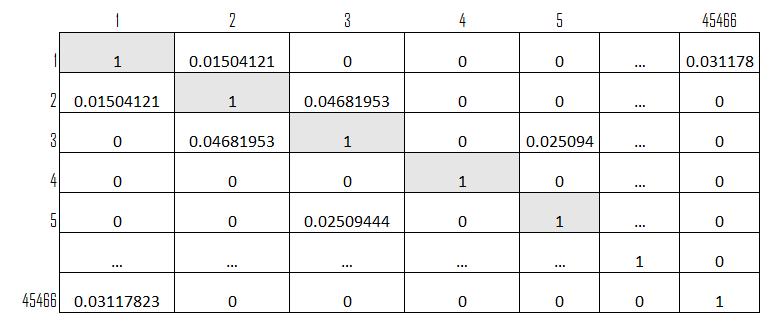

In [18]:
#observing the first 6 rows and 6 columns
for i in range(6):
    print(cosine_sim[i][:6])

[1.         0.01803865 0.         0.         0.         0.        ]
[0.01803865 1.         0.05327818 0.         0.         0.0588777 ]
[0.         0.05327818 1.         0.         0.02659259 0.        ]
[0.         0.         0.         1.         0.         0.01031911]
[0.         0.         0.02659259 0.         1.         0.        ]
[0.         0.0588777  0.         0.01031911 0.         1.        ]


6. Next, we need to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, you need a reverse mapping of movie titles and DataFrame indices. In other words, we are generating the ID for each movie title using index.

In [20]:
metadata['title']

0                          Toy Story
1                            Jumanji
2                   Grumpier Old Men
3                  Waiting to Exhale
4        Father of the Bride Part II
                    ...             
45461                         Subdue
45462            Century of Birthing
45463                       Betrayal
45464               Satan Triumphant
45465                       Queerama
Name: title, Length: 45466, dtype: object

In [21]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

#check the first 10 indices
indices[:10]

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
Heat                           5
Sabrina                        6
Tom and Huck                   7
Sudden Death                   8
GoldenEye                      9
dtype: int64

In [22]:
indices['Toy Story']

0

## Section 3 Content-Based Filtering Recommender

Now let's build a content filtering recommender. These are the following steps to follow:

(i) Get the index of the movie given its title.

(ii) Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position, and the second is the similarity score.

(iii) Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.

(iv) Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).

(v) Return the titles corresponding to the indices of the top elements.

In [23]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

In [24]:
get_recommendations('Toy Story')

485                                          Malice
448                               For Love or Money
314                        The Shawshank Redemption
180                                    Mute Witness
17                                       Four Rooms
427    City Slickers II: The Legend of Curly's Gold
370                                    Safe Passage
287                             Poison Ivy II: Lily
59                       The Indian in the Cupboard
492                          Much Ado About Nothing
Name: title, dtype: object

In [25]:
get_recommendations('GoldenEye')

12                             Balto
90                       Mary Reilly
158                     Crimson Tide
201    Under Siege 2: Dark Territory
31                    Twelve Monkeys
299           The Quick and the Dead
161            Devil in a Blue Dress
348                         The Crow
447                     Widows' Peak
174                Lord of Illusions
Name: title, dtype: object

In [26]:
get_recommendations('Muppet Treasure Island')

147                 Apollo 13
415     Beverly Hills Cop III
468           In the Army Now
144    The Basketball Diaries
180              Mute Witness
386             Jason's Lyric
424                 Cabin Boy
155                    Casper
85               White Squall
280              New York Cop
Name: title, dtype: object